In [ ]:
label_path=r'C:\Users\Dell\Desktop\yolo_models\archive\images_with_yolo_bb\labels\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6.txt'
image_path=r'C:\Users\Dell\Desktop\yolo_models\archive\images_with_yolo_bb\images\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6.jpg'

import cv2

with open(label_path,'r',encoding='utf-8', errors='ignore') as f:
    line=f.readline()

class_id, x_center, y_center, width, height=map(float,line.split())

img=cv2.imread(image_path)
h,w,_=img.shape

# Convert to pixel coordinates
x1 = int((x_center - width/2) * w)   # top-left x
y1 = int((y_center - height/2) * h)  # top-left y
x2 = int((x_center + width/2) * w)   # bottom-right x
y2 = int((y_center + height/2) * h)  # bottom-right y


cv2.rectangle(img,(x1,y1),(x2,y2),color=(0,255,0),thickness=2)

cv2.imshow('detected',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

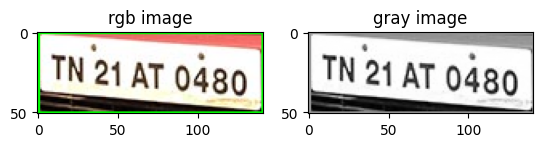

In [5]:
import matplotlib.pyplot as plt
import cv2 
ci=img[y1:y2,x1:x2]
rgb=cv2.cvtColor(ci,cv2.COLOR_BGR2RGB)
gray=cv2.cvtColor(ci,cv2.COLOR_BGR2GRAY)

plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title('rgb image')

plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.title('gray image')

plt.show()

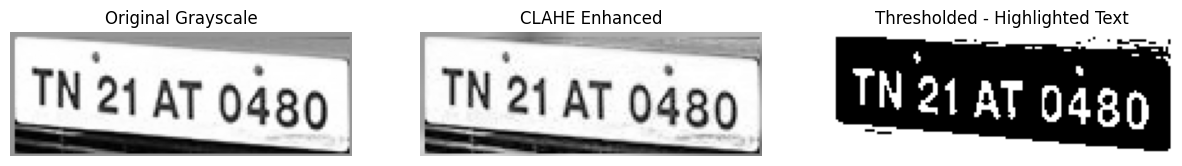

In [6]:
ci=img[y1:y2,x1:x2]
gray=cv2.cvtColor(ci,cv2.COLOR_BGR2GRAY)

# Binary Inverse Threshold: black text becomes white, background becomes black
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Use adaptive histogram equalization (CLAHE) to boost contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(gray)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(enhanced, cmap='gray')
plt.title('CLAHE Enhanced')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded - Highlighted Text')
plt.axis('off')

plt.show()


# augmenting the image for the yolo model

In [9]:
import cv2
import numpy as np
import random
import os
img=cv2.imread(image_path)
h,w=img.shape[:2]

In [10]:
label_path=label_path
import math

with open(label_path,'r') as f:
    line=f.readline().strip()
class_id, x_center, y_center, bw, bh = map(float,line.split())
print(class_id, x_center, y_center, bw, bh)
print(math.floor(x_center*w),math.ceil(y_center*h),math.ceil(bw*w),bh*h)

0.0 0.214375 0.580833 0.17625 0.085
171 349 141 51.00000000000001


In [11]:
image_path=image_path
label_path=label_path

def aug_image(image_path,label_path,save_dir,max_shift_ratio=0.1):
    img=cv2.imread(image_path)
    h,w=img.shape[:2]

    with open(label_path,'r') as f:
        line=f.readline().strip()
    class_id, x_center, y_center, bw, bh=map(float,line.split())

    # Convert from normalized to absolute pixel values
    x_center*=w
    y_center*=h
    bw*=w
    bh*=h

    x1 = x_center - bw/2
    x2 = x_center + bw/2
    y1 = y_center - bh/2
    y2 = y_center + bh/2

    # max_left= -min(x1, w*max_shift_ratio)
    # max_right= min(w-x2, w*max_shift_ratio)
    # max_up= -min(y1,h*max_shift_ratio)
    # max_down= min(h-y2, h*max_shift_ratio)
    max_left  = -min(x1, w * max_shift_ratio, x_center - bw/2)
    max_right =  min(w - x2, w * max_shift_ratio, w - (x_center + bw/2))
    max_up    = -min(y1, h * max_shift_ratio, y_center - bh/2)
    max_down  =  min(h - y2, h * max_shift_ratio, h - (y_center + bh/2))

                        # max_left  = -min(x1, w * max_shift_ratio, x_center - bw/2)
    # x1 → distance from the left edge of the box to the image left border
    # w * max_shift_ratio → maximum shift allowed by your augmentation setting
    # x_center - bw/2 → distance from box center to the left edge of the box
    
    # min() chooses the smallest value of the three.

    # ✅ That means:
            # Even if max_shift_ratio is huge (0.8), the shift is capped by either:
            # The box’s distance to the image edge
            # Or half of the box size (so the center doesn’t push it outside)

    # pick a random safe movement
    dx=random.randint(int(max_left),int(max_right))
    dy=random.randint(int(max_up),int(max_down))    

    # create a blank(black) canvas of same size
    shifted_img=np.zeros_like(img)

    # Define source and destination areas
    src_x1 = max(0,-dx)
    src_x2 = min(w,w-dx)
    dst_x1 = max(0,dx)
    dst_x2 = min(w,w+dx)
    
    src_y1 = max(0,-dy)
    src_y2 = min(h,h-dy)
    dst_y1 = max(0,dy)
    dst_y2 = min(h,h+dy)

    shifted_img[dst_y1:dst_y2,dst_x1:dst_x2] = img[src_y1:src_y2, src_x1:src_x2]

    new_x_center = (x_center + dx)/w
    new_y_center = (y_center + dy)/h
    new_bw = bw / w
    new_bh = bh / h

    os.makedirs(save_dir,exist_ok=True)
    base=os.path.splitext(os.path.basename(image_path))[0]
    new_img_path= os.path.join(save_dir,f"{base}_shifted.jpg")
    new_label_path = os.path.join(save_dir,f"{base}_shifted.txt")

    cv2.imwrite(new_img_path,shifted_img)
    with open(new_label_path,'w') as f:
        f.write(f"{int(class_id)} {new_x_center:.6f} {new_y_center:.6f} {new_bw:.6f} {new_bh:.6f}")
    
    print(f"[OK] Saved shifted image: {new_img_path}")
    print(f"Shift (dx={dx}, dy={dy})")


aug_image(
image_path=image_path,
label_path=label_path,
save_dir="augmented_simple",
max_shift_ratio=0.9
)


[OK] Saved shifted image: augmented_simple\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6_shifted.jpg
Shift (dx=196, dy=37)


In [6]:
image_path=image_path
label_path=label_path
import random
import numpy as np
import cv2
import os
def aug_image(image_path,label_path,save_dir,max_shift_ratio=0.1,augemted_img_number=2):
    img=cv2.imread(image_path)
    h,w=img.shape[:2]

    with open(label_path,'r') as f:
        line=f.readline().strip()
    class_id, x_center, y_center, bw, bh=map(float,line.split())

    # Convert from normalized to absolute pixel values
    x_center*=w
    y_center*=h
    bw*=w
    bh*=h

    x1 = x_center - bw/2
    x2 = x_center + bw/2
    y1 = y_center - bh/2
    y2 = y_center + bh/2

    # max_left= -min(x1, w*max_shift_ratio)
    # max_right= min(w-x2, w*max_shift_ratio)
    # max_up= -min(y1,h*max_shift_ratio)
    # max_down= min(h-y2, h*max_shift_ratio)
    for i in range(0,augemted_img_number):
        max_left  = -min(x1, w * max_shift_ratio, x_center - bw/2)
        max_right =  min(w - x2, w * max_shift_ratio, w - (x_center + bw/2))
        max_up    = -min(y1, h * max_shift_ratio, y_center - bh/2)
        max_down  =  min(h - y2, h * max_shift_ratio, h - (y_center + bh/2))

                            # max_left  = -min(x1, w * max_shift_ratio, x_center - bw/2)
        # x1 → distance from the left edge of the box to the image left border
        # w * max_shift_ratio → maximum shift allowed by your augmentation setting
        # x_center - bw/2 → distance from box center to the left edge of the box
        
        # min() chooses the smallest value of the three.

        # ✅ That means:
                # Even if max_shift_ratio is huge (0.8), the shift is capped by either:
                # The box’s distance to the image edge
                # Or half of the box size (so the center doesn’t push it outside)

                # pick a random safe movement
        dx=random.randint(int(max_left),int(max_right))
        dy=random.randint(int(max_up),int(max_down))    

        # create a blank(black) canvas of same size
        shifted_img=np.zeros_like(img)

        # Define source and destination areas
        src_x1 = max(0,-dx)
        src_x2 = min(w,w-dx)
        dst_x1 = max(0,dx)
        dst_x2 = min(w,w+dx)
        
        src_y1 = max(0,-dy)
        src_y2 = min(h,h-dy)
        dst_y1 = max(0,dy)
        dst_y2 = min(h,h+dy)

        shifted_img[dst_y1:dst_y2,dst_x1:dst_x2] = img[src_y1:src_y2, src_x1:src_x2]

        new_x_center = (x_center + dx)/w
        new_y_center = (y_center + dy)/h
        new_bw = bw / w
        new_bh = bh / h

        os.makedirs(save_dir,exist_ok=True)
        base=os.path.splitext(os.path.basename(image_path))[0]
        new_img_path= os.path.join(save_dir,f"{base}_shifted{i}.jpg")
        new_label_path = os.path.join(save_dir,f"{base}_shifted{i}.txt")

        cv2.imwrite(new_img_path,shifted_img)
        with open(new_label_path,'w') as f:
            f.write(f"{int(class_id)} {new_x_center:.6f} {new_y_center:.6f} {new_bw:.6f} {new_bh:.6f}")
        
        print(f"[OK] Saved shifted image {i}: {new_img_path}")
        print(f"Shift for {i} (dx={dx}, dy={dy})")


aug_image(
image_path=image_path,
label_path=label_path,
save_dir="augmented_simple",
max_shift_ratio=0.9,
augemted_img_number=5
)


[OK] Saved shifted image 0: augmented_simple\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6_shifted0.jpg
Shift for 0 (dx=543, dy=104)
[OK] Saved shifted image 1: augmented_simple\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6_shifted1.jpg
Shift for 1 (dx=-85, dy=6)
[OK] Saved shifted image 2: augmented_simple\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6_shifted2.jpg
Shift for 2 (dx=513, dy=-50)
[OK] Saved shifted image 3: augmented_simple\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6_shifted3.jpg
Shift for 3 (dx=-84, dy=-84)
[OK] Saved shifted image 4: augmented_simple\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6_shifted4.jpg
Shift for 4 (dx=480, dy=104)


# first yolo model

In [ ]:
!yolo detect train data="C:\Users\Dell\Desktop\yolo_models\data_path_yolo.yaml" model=yolov8n.pt epochs=15 imgsz=640

^C


# second yolo model

In [ ]:
!yolo detect train \
data=r'C:\Users\Dell\Desktop\yolo_models\data_path_yolo.yaml' \
model=yolov8n.pt \
epochs=100 \
patience=15 \
imgsz=640 \
degrees=20 perspective=0.001


New https://pypi.org/project/ultralytics/8.3.226 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.203 🚀 Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/alok_kumar/computer_vision/yolo_models/data_path_yolo.yaml, degrees=20, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0,

## prediction

In [ ]:
import os

path = r"C:\Users\Dell\Desktop\yolo_models\augmented_simple"
os.makedirs(os.path.join(path, 'images'), exist_ok=True)
os.makedirs(os.path.join(path, 'labels'), exist_ok=True)

In [ ]:
import os
import shutil

path = r"C:\Users\Dell\Desktop\yolo_models\augmented_simple"

os.makedirs(os.path.join(path, 'images'), exist_ok=True)
os.makedirs(os.path.join(path, 'labels'), exist_ok=True)

image_folder = os.path.join(path, 'images')
label_folder = os.path.join(path, 'labels')

for file in os.listdir(path):
    full_path = os.path.join(path, file)
    if file.endswith('.jpg'):
        shutil.move(full_path, os.path.join(image_folder, file))
    elif file.endswith('.txt'):
        shutil.move(full_path, os.path.join(label_folder, file))


In [ ]:
for file in os.listdir(r'C:\Users\Dell\Desktop\yolo_models\augmented_simple\images'):
    path=os.path.join(r'C:\Users\Dell\Desktop\yolo_models\augmented_simple\images',file)

    !yolo detect predict \
    model=r'C:\Users\Dell\Desktop\yolo_models\runs\detect\train4\weights\best.pt' \
    source="{path}" \
    save=True save_txt=True


Ultralytics 8.3.226  Python-3.10.19 torch-2.9.0+cpu CPU (Intel Core i7-8850H 2.60GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 C:\Users\Precision\Desktop\yolo_models\yolo_models\augmented_simple\images\0a720df9-e4ef-4e44-8c13-b39b9be8444d___3e7fd381-0ae5-4421-8a70-279ee0ec1c61_Nissan-Terrano-6_shifted0.jpg: 480x640 1 car, 126.1ms
Speed: 6.0ms preprocess, 126.1ms inference, 14.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to C:\Users\Precision\Desktop\yolo_models\yolo_models\runs\detect\predict
1 label saved to C:\Users\Precision\Desktop\yolo_models\yolo_models\runs\detect\predict\labels
 Learn more at https://docs.ultralytics.com/modes/predict
Ultralytics 8.3.226  Python-3.10.19 torch-2.9.0+cpu CPU (Intel Core i7-8850H 2.60GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 C:\Users\Precision\Desktop\yolo_models\yolo_models\augmented_simple\images\0a720df9-e4ef-4e44-8c13-b3